## This is a FSI problem of 2D cylinder falling in a quiescent flow

Considering the fictitious fluid inside the cylinder due to immersed boundary method, also considering buoyancy.

To keep consistency between *Dyn3d* and *ViscousFlow*, the cylinder is setup in z-x coordinates, so gravity should also be set in z direction

In [1]:
using Revise
using BSON: @save, @load

using Plots
pyplot()
default(grid = false)

In [2]:
using Pkg
Pkg.activate("../..")
using FSI

In [3]:
filename = "RisingCylinder_rho=0.5_2";

## Load initial condition from outside files

In [4]:
using ViscousFlow
@load "RisingCylinder_rho=0.5_1.bson" w qJ v

In [5]:
qJ

6-element Array{Float64,1}:
  0.0                 
  9.272070197250832e-7
  0.0                 
  9.503716741437235e-7
  0.0                 
 -0.4999999998553785  

In [6]:
v

6-element Array{Float64,1}:
  0.0                  
  2.781615615725372e-6 
  0.0                  
  1.6049538525211876e-6
  0.0                  
 -0.9999999985362859   

## <span style="color:blue"> Set up rigid body with Dyn3d.jl

#### Include any joint-body setup script from Dyn3d

In [7]:
ndim = 2
# numerical params
tf = 1.0
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0.0, -1.0]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
function circle(z₀::Vector{Float64}, r::Float64, n::Int)
    # z₀ for circle center location, r for radius and n for # of points on circle
    verts = zeros(n,2)
    for i = 1:n
        verts[i,:] = [r*cos(2π/(n)*(i-1)) + z₀[1], r*sin(2π/(n)*(i-1)) + z₀[2]]
    end
    return verts
end

nbody = 1
nverts = 157
verts = circle([0.,0.], 0.5, nverts)
config_body = ConfigBody(nbody, nverts, verts, 0.5)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)

# set the first passive joint with no stiff and damp
dofₚ = Dof(6, "passive", 0., 0., Motions())
config_joints[1] = ConfigJoint(njoint, "custom_prismatic_in_z",
    [0.0,0.0,0.0,2.0,0.0,3.2+qJ[6]], zeros(Float64,6), 0, [dofₚ], [0.0],[v[6]])

 joint type = custom_prismatic_in_z
 joint position in parent body coord = [0.0, 0.0, 0.0, 2.0, 0.0, 2.7]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 6, under passive motion
 initial unconstrained dof position = [0.0]
 initial unconstrained dof velocity = [-1.0]


#### Build joint-body chain

In [8]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

This is a 1 body-joint system, system is un-mounted from space

#### Initialize rigid body system state to complete body-joint information

In [9]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [10]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [11]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

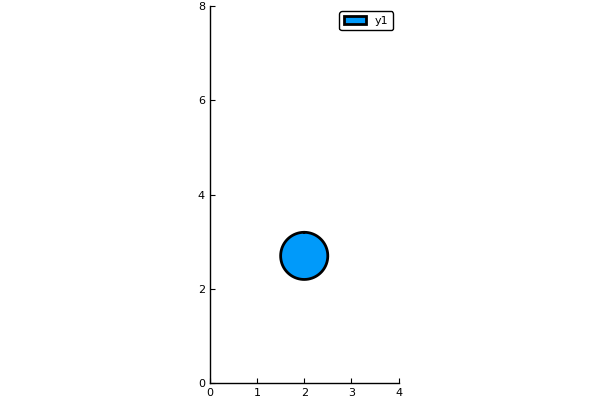

In [12]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,[1:nverts;1],1], vs₀[i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
end
plot!(xlims=(0,4), ylims=(0,8),ratio=1)
# plot!(xlims=(0,2), ylims=(0,3),ratio=1)

## <span style="color:blue"> Set up fluid with ViscousFlow.jl </span>

#### Set the flow parameters

In [13]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 0.0)

#### Set the domain grid

In [14]:
nx = 202; ny = 402;
Ly = 8.0;
# nx = 102; ny = 152;
# Ly = 3.0;
Δx = Ly/(ny-2);

Δt = min(0.5*Δx,0.5*Δx^2*Re)

w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:4.01, -0.01:0.02:8.01)

#### Set up fluid initial conditions - already set at the beginning

In [15]:
# w₀ .= 0.0;
# w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [16]:
plane = [1,3];

#### Genrate body grid points and get linear velocity on them

In [17]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx));

#### Get body points initial coordinates for fluids

In [18]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [19]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [20]:
tf = 1000Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2
Δt

0.01

## <span style="color:blue"> Create ifherk object </span>

In [21]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> FSI.Systems.plan_intfact(t,u,fsys), FSI.B₁ᵀ, FSI.B₂),
                (M, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSI.r₁(w,t,fsys), bd -> F(bd,config_body.ρ), w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3, rk=FSI.TimeMarching.RK31, bodydim=2, ρb=config_body.ρ)

 29.567148 seconds (59.00 M allocations: 6.149 GiB, 3.28% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [22]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [ ]:
@time for ti in T

    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")

end

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [45]:
contour_levels = range(minimum(w.data),stop=maximum(w.data),length=40)
sample_freq = 5
fps = 25;

#### Get body verts history

In [47]:
vshist = []
for i = 1:length(bdhist)
    push!(vshist, VertsHistory(bdhist[i].sys.nbody, bdhist[i].bs))
end
fb = [1:nverts;1];

#### Plot first and last time field

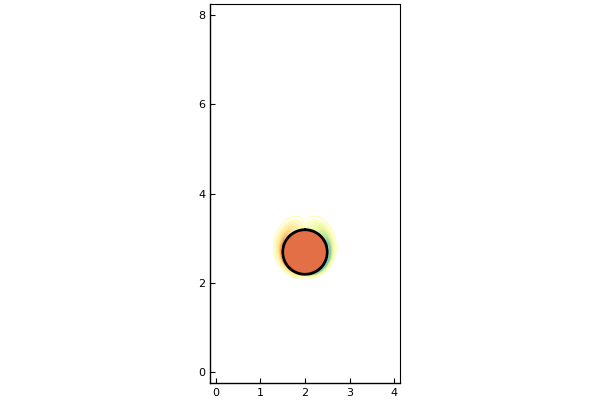

In [48]:
p = plot(xg,yg,whist[1],levels=contour_levels,color=:RdBu_10)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,fb,1], vshist[1][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
p

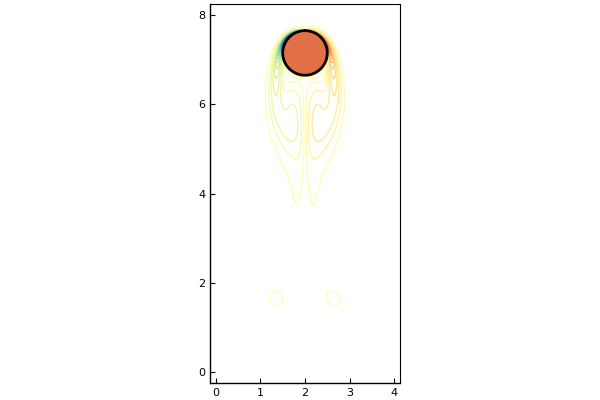

In [49]:
p = plot(xg,yg,whist[end],levels=contour_levels,color=:RdBu_10)
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,fb,1], vshist[end][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

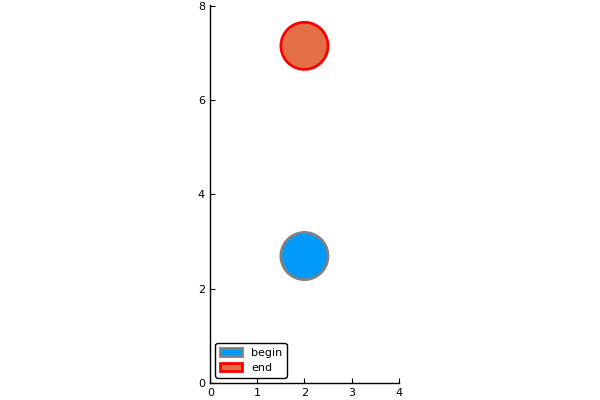

In [50]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,fb,1], vshist[1][i,fb,plane[2]],linewidth=2,linecolor="grey",label="begin",fill=true)
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,fb,1], vshist[end][i,fb,plane[2]],linewidth=2,linecolor="red",label="end",fill=true)
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1)
pb

#### Make gif

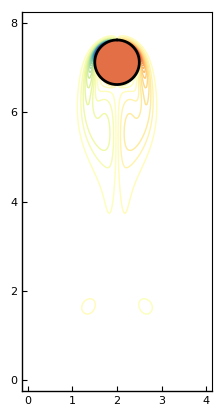

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/light_cylinder_fall_2.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/light_cylinder_fall_2.gif")

In [51]:
anim = @animate for j = 1:sample_freq:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels,color=:RdBu_10)
    for i = 1:sys.nbody
        plot!(vshist[j][i,fb,1], vshist[j][i,fb,plane[2]],linewidth=2,linecolor="black",fill=true)
    end
end

gif(anim, filename*".gif", fps = fps)

#### Get cylinder position and velocity in time

In [52]:
vhist = [0.0]
phist = [0.0]

for i in 1:length(bdhist)
    push!(vhist,bdhist[i].bs[1].v[6])
    push!(phist,bdhist[i].bs[1].x_i[3]-bdhist[1].bs[1].x_i[3])    
end

ahist = []
for i in 1:length(vhist)-1
    push!(ahist,(vhist[i+1]-vhist[i])/Δt)
end

#### Plot cylinder position, velocity, acceleration

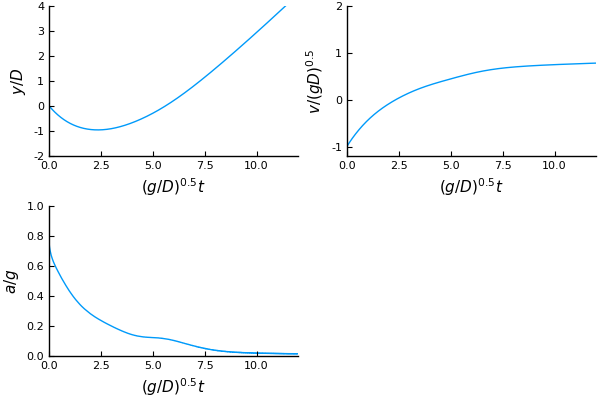

In [59]:
pp = plot([0.0;thist],phist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$y/D\$",legend=false,xlims=(0,t),ylims=(-2,4))
pv = plot([0.0;thist],vhist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$v/(gD)^{0.5}\$",legend=false,xlims=(0,t),ylims=(-1.2,2))
pa = plot([0.0;thist[1:end-1]],ahist,xlabel="\$(g/D)^{0.5}t \$",ylabel="\$a/g\$",legend=false,xlims=(0,t),ylims=(0,1))

plot(pp,pv,pa)

In [54]:
ahist[end]

0.014776295496332637

#### Lift and drag coefficients

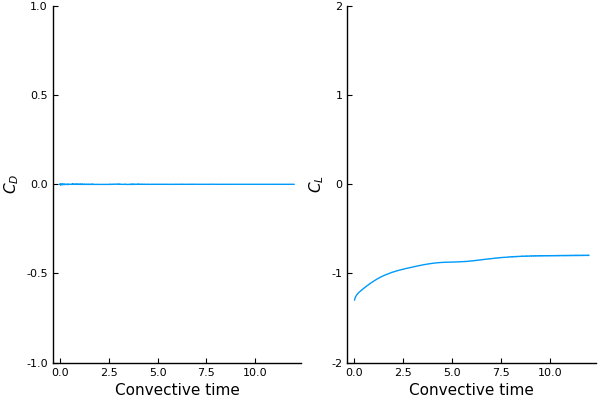

In [55]:
px = plot(thist,2*fx,ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(-2,2),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

## <span style="color:blue"> Save Data </span>

#### Save all current data .bson file

In [56]:
# @save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [57]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);